# Optimal algorithm for price prediction

## 1. Data preparation

### 1.1 Data loading

In [2]:
# required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb

import time
import warnings

warnings.filterwarnings("ignore")

In [4]:
# load the data
df = pd.read_csv("car_data.csv", parse_dates=True, infer_datetime_format=True)
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [5]:
# print out the info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
# calcualte number of missing values and their percentages in each columns of every data file
def missing_data(list_of_dfs, list_of_names=None):
    for i in range(len(list_of_dfs)):
        df = list_of_dfs[i]
        col_names = df.columns.tolist()
        na_per_col = df.isna().sum().tolist()
        na_percentage = (df.isna().sum() / len(df) * 100).tolist()
        if list_of_names != None:
            print("=" * 20, "Missing values of", list_of_names[i], "=" * 20)
        display(
            pd.DataFrame(
                list(zip(na_per_col, na_percentage)),
                columns=["Number of missings", "% of missings"],
                index=col_names,
            ).style.background_gradient(axis=0)
        )


# apply the function
missing_data([df])

,Number of missings,% of missings
DateCrawled,0,0.000000
Price,0,0.000000
VehicleType,37490,10.579368
RegistrationYear,0,0.000000
Gearbox,19833,5.596709
Power,0,0.000000
Model,19705,5.560588
Mileage,0,0.000000
RegistrationMonth,0,0.000000
FuelType,32895,9.282697


columns_with_missing_values = ['vehicletype','gearbox', 'model', 'fueltype', 'notrepaired'] 

In [7]:
# check for number of duplicated rows
display(df.duplicated().sum())
print(f"Percentage of duplicated rows is {df.duplicated().sum()/len(df):.2%}.")

262

Percentage of duplicated rows is 0.07%.


In [8]:
# retreiev which rows were repeated
duplicates = df.duplicated(keep=False)
df.loc[duplicates].sort_values(["DateCrawled"])

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
90786,01/04/2016 05:02,6199,coupe,1999,manual,193,3er,150000,5,petrol,bmw,no,01/04/2016 00:00,0,99974,07/04/2016 06:15
87112,01/04/2016 05:02,6199,coupe,1999,manual,193,3er,150000,5,petrol,bmw,no,01/04/2016 00:00,0,99974,07/04/2016 06:15
45825,01/04/2016 10:38,3499,small,2005,manual,86,getz,50000,5,petrol,hyundai,no,01/04/2016 00:00,0,47800,07/04/2016 06:46
142496,01/04/2016 10:38,3499,small,2005,manual,86,getz,50000,5,petrol,hyundai,no,01/04/2016 00:00,0,47800,07/04/2016 06:46
12578,01/04/2016 12:57,1499,wagon,1995,manual,150,5er,150000,6,petrol,bmw,no,01/04/2016 00:00,0,25821,07/04/2016 09:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68628,31/03/2016 19:51,999,small,1998,manual,60,corsa,150000,5,petrol,opel,no,31/03/2016 00:00,0,85111,06/04/2016 14:18
228351,31/03/2016 20:25,9600,sedan,2006,manual,226,focus,125000,4,petrol,ford,no,31/03/2016 00:00,0,55469,06/04/2016 14:15
27192,31/03/2016 20:25,9600,sedan,2006,manual,226,focus,125000,4,petrol,ford,no,31/03/2016 00:00,0,55469,06/04/2016 14:15
30499,31/03/2016 23:51,5999,wagon,2007,manual,120,astra,150000,3,gasoline,opel,no,31/03/2016 00:00,0,95482,07/04/2016 00:17


> **Issues identified so far: 
- Columns names should be in lowercase;
- data types of several columns;
- 5 columns have missing values and `power` col has zeros, should be dealed;
- 262 duplicated values for now (after filling missing values these may increase)

### 1.2 Preprocessing

#### 1.2.1 Columns names

In [9]:
# convert column names to lowercase
df.columns = df.columns.str.lower().str.strip()
df.head(1)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16


#### 1.2.2 Column dtypes

In [10]:
df[["datecrawled", "datecreated", "lastseen"]] = df[
    ["datecrawled", "datecreated", "lastseen"]
].apply(pd.to_datetime, infer_datetime_format=True)
df.dtypes

datecrawled          datetime64[ns]
price                         int64
vehicletype                  object
registrationyear              int64
gearbox                      object
power                         int64
model                        object
mileage                       int64
registrationmonth             int64
fueltype                     object
brand                        object
notrepaired                  object
datecreated          datetime64[ns]
numberofpictures              int64
postalcode                    int64
lastseen             datetime64[ns]
dtype: object

#### 1.2.3 Missing values

In [11]:
columns_with_missing_values = [
    "vehicletype",
    "gearbox",
    "model",
    "fueltype",
    "notrepaired",
]
df[columns_with_missing_values] = df[columns_with_missing_values].fillna("unknown")
df.isna().sum()

datecrawled          0
price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
mileage              0
registrationmonth    0
fueltype             0
brand                0
notrepaired          0
datecreated          0
numberofpictures     0
postalcode           0
lastseen             0
dtype: int64

#### 1.2.4 Duplicates

In [12]:
print(
    f"Number of duplicated rows {df.duplicated().sum()} and total number of rows {df.shape[0]}."
)
df = df.drop_duplicates()
print()
print("=" * 20, "After dropping ducplicates", "=" * 20)
print(
    f"Number of duplicated rows {df.duplicated().sum()} and total number of rows {df.shape[0]}."
)

Number of duplicated rows 262 and total number of rows 354369.

==================== After dropping ducplicates ====================
Number of duplicated rows 0 and total number of rows 354107.


#### 1.2.5 Create an age column

In [13]:
# check descriptive statistics of registrationyear and datecrated columns
df.registrationyear.describe(), df.datecreated.dt.year.describe()

(count    354107.000000
 mean       2004.235355
 std          90.261168
 min        1000.000000
 25%        1999.000000
 50%        2003.000000
 75%        2008.000000
 max        9999.000000
 Name: registrationyear, dtype: float64,
 count    354107.000000
 mean       2015.999924
 std           0.009049
 min        2014.000000
 25%        2016.000000
 50%        2016.000000
 75%        2016.000000
 max        2016.000000
 Name: datecreated, dtype: float64)

In [14]:
# select year below 1900 and above the 'datecreated'
condition = (df["registrationyear"] > df["datecreated"].dt.year) | (
    df["registrationyear"] < 1900
)
display(len(df[condition]) / len(df) * 100)
print()

# select data which does not have above condition
df = df[~(condition)]

# calculate the age of vehicles
df["vehicleage"] = df["datecreated"].dt.year - df["registrationyear"]

# check the result
df.head(2)

4.121635550836329

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen,vehicleage
0,2016-03-24 11:52:00,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-07-04 03:16:00,23
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-07-04 01:46:00,5


### 1.3 Conclusion

- Data, with **354369 rows and 16 columns**, has been imported and checked, following observations/changes were made:
    - Columns names of data were in mixed case, all were converted to lowercase;
    - `datecrawled`, `datecreated`, and `lastseen` columns were containing date but loaded as object data type. They were converted to the datetime data type of pandas;
    - `vehicletype`, `gearbox`, `model`, `fueltype`, and `notrepaired` columns were containing missing values. These all columns hold categorical data types. Therefore, all missing values were filled as "unknown";
    - In total 262 rows were duplicated in original data. It was found that they were identical duplicates. They were all dropped;
    - A new column which contains the age of the vehicle, `vehicleage`, was created using `datecreated` and `registrationyear` columns. However, in this step, it was observed that data was containing error in `registrationyear` columns, there were years as low as 1000 and as high as 9999. All years smaller than 1900 (it is the year when cars became commercial) and higher than the profile date creation were dropped. Dropped amount of rows were around 4% of the data.


All mentioned errors might be originated due to technical reasons, human error (typo), or during web crawling, dataset joining, etc.

## 2. EDA

Let's get familiar with the data more by visualizing their data by plotting some charts.

### 2.1 Numerical columns

In [15]:
# select all numerical columns of data
numerical_cols = ["price", "power", "mileage", "vehicleage"]

# print out descriptive statistics of numerical columns
df[numerical_cols].describe()

,price,power,mileage,vehicleage
count,339512.000000,339512.000000,339512.000000,339512.000000
mean,4471.106815,110.998374,128086.753929,13.518061
std,4546.229568,186.945091,37896.907472,7.091876
min,0.000000,0.000000,5000.000000,0.000000
25%,1099.000000,69.000000,125000.000000,9.000000
50%,2799.000000,105.000000,150000.000000,13.000000
75%,6500.000000,143.000000,150000.000000,17.000000
max,20000.000000,20000.000000,150000.000000,106.000000


> It seems like we still have error in our data. E.g. a car can not have horsepower as high as 20000. Little google search resulted that the car with highest horsepower untill now is 1500 https://en.wikipedia.org/wiki/List_of_production_cars_by_power_output

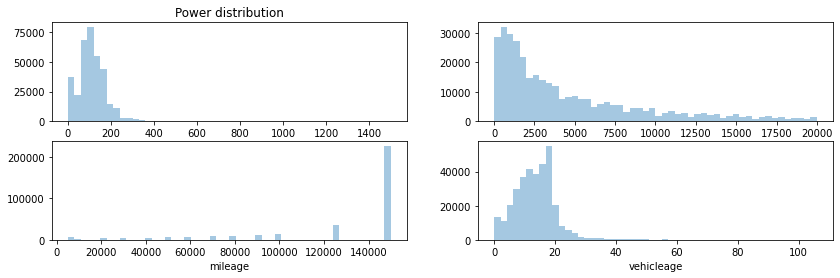

In [16]:
# histograms of all numerical columns
fig, ax = plt.subplots(2, 2, figsize=(14, 4))
sns.distplot(df["power"], kde=False, hist_kws={"range": (0, 1500)}, ax=ax[0, 0])
ax[0, 0].set_title("Power distribution")
sns.distplot(df["price"], kde=False, ax=ax[0, 1])
sns.distplot(df["mileage"], kde=False, hist_kws={"range": (5000, 150000)}, ax=ax[1, 0])
sns.distplot(df["vehicleage"], kde=False, ax=ax[1, 1])

plt.show()

In [17]:
# calculate the outliers in 'power' columns
(
    df["power"].quantile(0.75)
    + (df["power"].quantile(0.75) - df["power"].quantile(0.25)) * 1.5
)

254.0

8038 0.12400150804684369


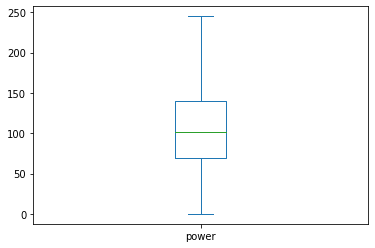

In [18]:
# How many rows and what percentage in total has outliers in the 'power' columns
print(len(df[df["power"] > 245]), len(df[df["power"] > 500]) / len(df) * 100)

# select all rows where the 'power' values is smaller than 245
df = df[~(df["power"] > 245)]

# plot the boxplot
df["power"].plot(kind="box")
plt.show()

### 2.2 Categorical columns

In [19]:
# descriptive statistics of categorical columns
categorical_cols = ["vehicletype", "gearbox", "model", "fueltype", "brand"]
df[categorical_cols].describe()

,vehicletype,gearbox,model,fueltype,brand
count,331474,331474,331474,331474,331474
unique,9,3,250,8,40
top,sedan,manual,golf,petrol,volkswagen
freq,88048,255167,27315,203857,72503


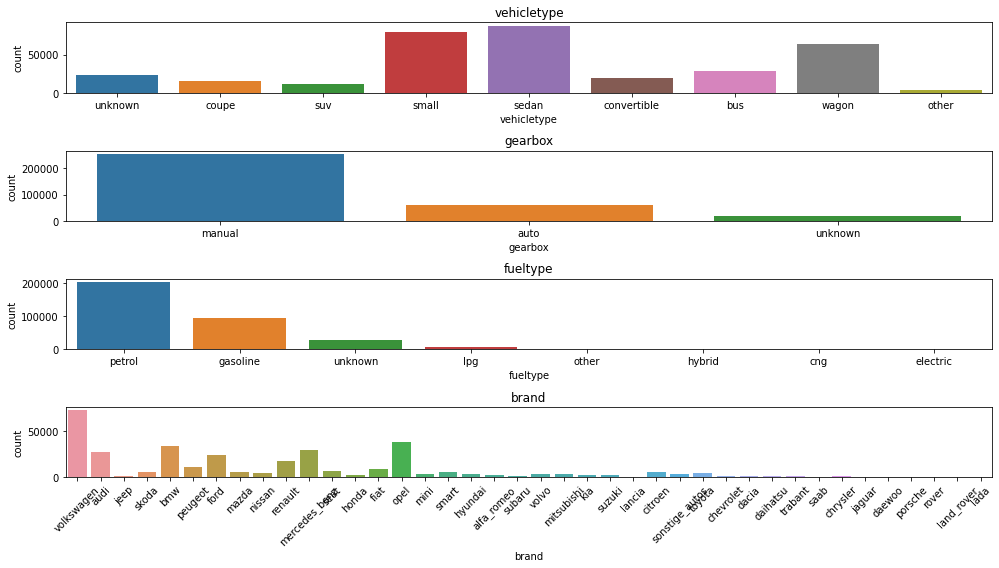

In [20]:
# plots showing number of each type of vehicle, gearbox, fueltype and car brand in datasets
fig, ax = plt.subplots(4, 1, figsize=(14, 8))
for i, j in enumerate(["vehicletype", "gearbox", "fueltype", "brand"]):
    sns.countplot(df[j], ax=ax[i])
    ax[i].set_title(j)
ax[3].tick_params(
    axis="x",
    rotation=45,
)
plt.tight_layout()
plt.show()

### 2.3 Conclusion
During EDA, it was observed that there was an error in the `power` column, which were containing horsepower values as high as 20000. All values above the Q3+IQR*1.5 were dropped (it was only 0.12% of the data). 

It was observed that ** the most sold:
- brand: Volkswagen
- model: golf
- vehicle type: sedan 
- gearbox: manual (more than two-thirds of all)
- fuel type: petrol (about two-thirds of all)

## 3. Model training
In this section we will train different model, and tune some hyperparameters, if possible of course. Following algorithms we are going to use:
 - LinearRegression
 - RandomForestRegressor (with different n_estimators and max_depth)
 - CatBoostRegressor (with different number of iterations and depth)
 - LightBGMRegressor (with different n_estimaros and max_depth)
 - XGBoostRegressor (with default parameters)
 
However, before that, we should mention that we don't need all columns of the data. Because some of the columns will not add value to our prediction. Therefore we will select the most important columns.

In [21]:
# Select columns which are important for modeling
selected_cols = [
    "price",
    "vehicletype",
    "gearbox",
    "power",
    "model",
    "mileage",
    "fueltype",
    "brand",
    "vehicleage",
]
df = df[selected_cols]

# what is the shape of new dataframe
df.shape

(331474, 9)

In [22]:
# define categorical and numerical columns, we will use them throught algorithm trainings
categorical_columns = ["vehicletype", "gearbox", "model", "fueltype", "brand"]
numerical_columns = ["power", "mileage", "vehicleage"]

### 3.1 LinearRegression

In [23]:
# for regression one hot encoding works well
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.shape

# get target and feature columns
X = df_ohe.drop("price", axis=1)
y = df_ohe["price"]

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=234
)

# scaling is crucial for regression models
numerical_columns = ["power", "mileage", "vehicleage"]
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [24]:
%%time
#linear regression model, train and predict results
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

Wall time: 13.2 s


LinearRegression()

In [25]:
%%time
#predict the target and calculate RMSE and check time for prediction
y_pred = lr_model.predict(X_test)
#Scores
print(f'The RMSE score of the linear regression model is {(mean_squared_error(y_test, y_pred))**0.5}.')

The RMSE score of the linear regression model is 2766.0508416273915.
Wall time: 281 ms


### 3.2 RandomForestRegressor

> we will use OrindalEncoding class of sklearn for encoding categorical columns, it works better than OHE for tree-based algorithms. Data prepared in this step will be used for RandomForest, LightGBM and XGBoost. For Catboost we will prepare separate data, because it can handle categorical data.

In [26]:
# get categorical column names
df_lbe = df.copy()

# construct the encoder
encoder = OrdinalEncoder()

# encode categorical columns and change the values in the dataframe
encoded = encoder.fit_transform(df_lbe[categorical_columns])
df_lbe[categorical_columns] = encoded

# check new df
df_lbe.head(2)

,price,vehicletype,gearbox,power,model,mileage,fueltype,brand,vehicleage
0,480,7.0,1.0,0,116.0,150000,6.0,38.0,23
1,18300,2.0,1.0,190,227.0,125000,2.0,1.0,5


In [27]:
# get target and feature columns from df_lbe
X = df_lbe.drop("price", axis=1)
y = df_lbe["price"]

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=234
)

In [28]:
# for loop to check optimal n_estimators
for n in [30, 50]:
    rf_model = RandomForestRegressor(n_estimators=n, n_jobs=-1, random_state=234)
    mse = cross_val_score(
        rf_model, X_train, y_train, scoring="neg_mean_squared_error", cv=3
    )
    rmse = np.sqrt(mse * -1)
    avg_rmse = np.sum(rmse) / len(rmse)
    print(
        f"The average RMSE score of the RandomForest model with {n} estimators is {avg_rmse}."
    )
    print()

# for loop to find optimal max_depth values
for n in [7, 15]:
    rf_model = RandomForestRegressor(
        n_estimators=30, max_depth=n, n_jobs=-1, random_state=234
    )
    mse = cross_val_score(
        rf_model, X_train, y_train, scoring="neg_mean_squared_error", cv=3
    )
    rmse = np.sqrt(mse * -1)
    avg_rmse = np.sum(rmse) / len(rmse)
    print(
        f"The average RMSE score of the RandomForest model with max_depth={n} is {avg_rmse}."
    )
    print()

The average RMSE score of the RandomForest model with 30 estimators is 1770.1783591307114.

The average RMSE score of the RandomForest model with 50 estimators is 1763.309984696877.

The average RMSE score of the RandomForest model with max_depth=7 is 2139.9130325012443.

The average RMSE score of the RandomForest model with max_depth=15 is 1763.9865281457915.



When n_estimators are too large, model's RMSE scores is slightly improving but using such a high n_estimators really slows down the computation. For the sake of speed, we will chose n_estimators of 50 and max_depth of 20.
Let's find how much time required for the optimal model with RandomForestRegressor

In [29]:
%%time
#build a model with optimal parameters and check how much time it requires for training
best_rf_model = RandomForestRegressor(n_estimators = 50, max_depth=15, n_jobs=-1, random_state=234)
best_rf_model.fit(X_train, y_train)

Wall time: 17 s


RandomForestRegressor(max_depth=15, n_estimators=50, n_jobs=-1,
                      random_state=234)

In [30]:
%%time
#now let's check how much time it requires for prediction and calcualte the RMSE
y_pred = best_rf_model.predict(X_test)

print(f'The RMSE score of the best RandomForestRegression model is {(mean_squared_error(y_test, y_pred))**0.5}.')

The RMSE score of the best RandomForestRegression model is 1754.4200140924252.
Wall time: 444 ms


### 3.3 LightGBMRegressor

In [31]:
# for loop to find optimal n_estimators
for n in [30, 50]:
    lg_model = LGBMRegressor(n_estimators=n, random_state=234)
    mse = cross_val_score(
        lg_model, X_train, y_train, scoring="neg_mean_squared_error", cv=3
    )
    rmse = np.sqrt(mse * -1)
    avg_rmse = np.sum(rmse) / len(rmse)
    print(f"The RMSE score of the LightGBM model with {n} estimators is {avg_rmse}.")
    print()

# for to find optimal max_depth
for n in [7, 15]:
    lg_model = LGBMRegressor(n_estimators=30, max_depth=n, random_state=234)
    mse = cross_val_score(
        lg_model, X_train, y_train, scoring="neg_mean_squared_error", cv=3
    )
    rmse = np.sqrt(mse * -1)
    avg_rmse = np.sum(rmse) / len(rmse)
    print(f"The RMSE score of the LightGBM model with max_depth={n} is {avg_rmse}.")
    print()

The RMSE score of the LightGBM model with 30 estimators is 1982.904491418236.

The RMSE score of the LightGBM model with 50 estimators is 1868.479333522558.

The RMSE score of the LightGBM model with max_depth=7 is 1989.3441819444317.

The RMSE score of the LightGBM model with max_depth=15 is 1982.904491418236.



In [32]:
%%time

#build a model with optimal parameters and check how much time it requires for training
best_lg_model = LGBMRegressor(n_estimators=50, max_depth=15, random_state=234)
best_lg_model.fit(X_train, y_train)

Wall time: 1.13 s


LGBMRegressor(max_depth=15, n_estimators=50, random_state=234)

In [33]:
%%time
# predict the target and check RMSE score and time it requires for prediction
y_pred = best_lg_model.predict(X_test)
print(f'The RMSE score of the best LightGBM model is {(mean_squared_error(y_test, y_pred))**0.5}.')

The RMSE score of the best LightGBM model is 1888.525685137322.
Wall time: 181 ms


### 3.4 XGBoostRegressor

In [34]:
%%time
#calculate the time required for training
xg_model = xgb.XGBRegressor()
xg_model.fit(X_train,y_train)

Wall time: 11.8 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
%%time
#do prediction and check RMSE score and time it requires
y_pred = xg_model.predict(X_test)

print(f'The RMSE score of the XGBoost model with defualt parameters is {(mean_squared_error(y_test, y_pred))**0.5}.')

The RMSE score of the XGBoost model with defualt parameters is 1745.2050153705543.
Wall time: 154 ms


### 3.5 CatboostRegressor

In [36]:
# get target and feature columns from df without encoding
X = df.drop("price", axis=1)
y = df["price"]

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=234
)

# for loop the check optimal number of iterations
for n in [30, 50]:
    cb_model = CatBoostRegressor(
        iterations=n,
        learning_rate=1,
        random_seed=234,
        silent=True,
        cat_features=categorical_columns,
    )
    mse = cross_val_score(
        cb_model, X_train, y_train, scoring="neg_mean_squared_error", cv=3
    )
    rmse = np.sqrt(mse * -1)
    avg_rmse = np.sum(rmse) / len(rmse)
    print(f"The RMSE score of the Catboost model with {n} iterations is {avg_rmse}.")
    print()

# for loop the check optimal number of depth
for n in [7, 15]:
    cb_model = CatBoostRegressor(
        iterations=30,
        learning_rate=1,
        depth=n,
        random_seed=234,
        silent=True,
        cat_features=categorical_columns,
    )
    mse = cross_val_score(
        cb_model, X_train, y_train, scoring="neg_mean_squared_error", cv=3
    )
    rmse = np.sqrt(mse * -1)
    avg_rmse = np.sum(rmse) / len(rmse)
    print(f"The RMSE score of the Catboost model with depth={n} is {avg_rmse}.")
    print()

The RMSE score of the Catboost model with 30 iterations is 1858.0889667967595.

The RMSE score of the Catboost model with 50 iterations is 1826.9967002786213.

The RMSE score of the Catboost model with depth=7 is 1842.8976274074018.

The RMSE score of the Catboost model with depth=15 is 1830.9026477972693.



In [37]:
%%time

#build the model with optimal parameters and check how much time it requires for training
best_cb_model = CatBoostRegressor(iterations=50, learning_rate=1, depth=15, random_seed=234, silent=True)
best_cb_model.fit(X_train, y_train, cat_features=categorical_columns)

Wall time: 41.2 s


In [38]:
%%time
#predict the target and check RMSE score and time
y_pred = best_cb_model.predict(X_test)

print(f'The RMSE score of the best Catboost model is {(mean_squared_error(y_test, y_pred))**0.5}.')

The RMSE score of the best Catboost model is 1823.2683654995737.
Wall time: 270 ms


### 3.6 Conclusion

Some columns, such as `NumberOfPictures` which contains all zeros and other datetime columns, will not add much value to our regression models. Therefore, we have selected most important columns as following: `price`, `vehicletype`, `gearbox`, `power`, `model`, `mileage`, `fueltype`, `brand`, and `vehicleage`. New data for training and testing models has 331474 rows and 9 columns (just for comparison, initial data were containing: **354369 rows and 16 columns**. Duplicates, errors and unnecessary data were dropped.)

Following algorithms were trained and test:

|Algorithm            |Deal with categoricals|Scaling        |Tuned Hyperparamteres  |
|---------------------|----------------------|---------------|-----------------------|
|LinearRegression     |One hot encoding      |StandardScaler |None                   |
|RandomForestRegressor|Label encoding        |None           |n_estimators, max_depth|
|LightGBMRegressor    |Label encoding        |None           |n_estimators, max_depth|
|XGBoostRegressor     |Label encoding        |None           |None                   |
|CatBoostRegressor    |it has its own        |None           |iterations, depth      |

## 4. Performance comparison of models

Here we will compare the RMSE score and how much time was required to get an optimal score with the above models.

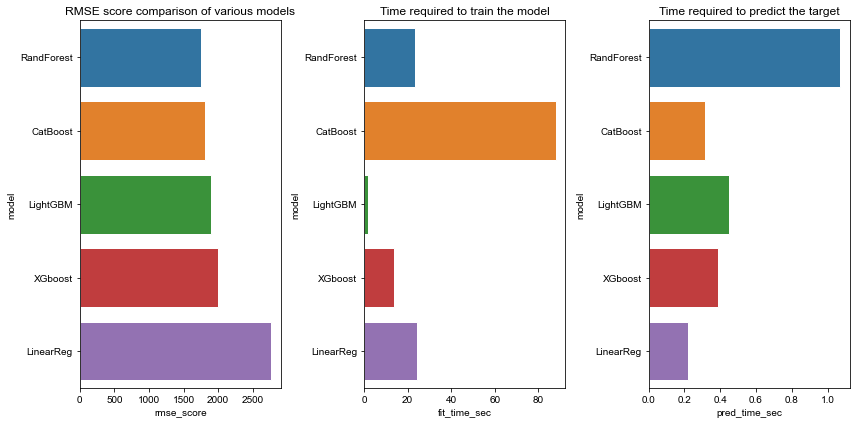

In [39]:
# performace of best models
models = ["LinearReg", "RandForest", "LightGBM", "XGboost", "CatBoost"]
rmse_score = [2766.05, 1754.42, 1888.53, 1990.81, 1814.9]
fit_time = [24.1, 23.4, 1.65, 13.9, 88]
pred_time = [0.22, 1.07, 0.45, 0.39, 0.313]
# ceate a dataframe
comparison = pd.DataFrame(
    data=zip(models, rmse_score, fit_time, pred_time),
    columns=["model", "rmse_score", "fit_time_sec", "pred_time_sec"],
)

# plot performance metrics
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
sns.set_style("whitegrid")


sns.barplot(
    data=comparison.sort_values("rmse_score"),
    y="model",
    x="rmse_score",
    orient="h",
    ax=ax[0],
)
ax[0].set_title("RMSE score comparison of various models")
sns.barplot(
    data=comparison.sort_values("rmse_score"),
    y="model",
    x="fit_time_sec",
    orient="h",
    ax=ax[1],
)
ax[1].set_title("Time required to train the model")
sns.barplot(
    data=comparison.sort_values("rmse_score"),
    y="model",
    x="pred_time_sec",
    orient="h",
    ax=ax[2],
)
ax[2].set_title("Time required to predict the target")


plt.tight_layout()
plt.show()

### 4.1 Conclusion

Overall, from the perspective of RMSE score, all models performed well compared to the simple **LinearRegression, which estimates the price of the car with $\pm$ 2766 EUR.** However, RMSE scores of **RandomForest were the lowest ($\pm$ 1754 EUR)**, but LightGBM and CatBoost also performed comparably to RandomForest. 


On other hand, the times for training the model and predicting the target were significantly different. For example, RandomForest, which had the highest RMSE score, required 23 seconds for training and as high as 1.1 seconds for prediction, while
the simple **LinearRegression model required 24 seconds for training and only 0.22 seconds for prediction. 

In our opinion, prediction time is more important than training time. Because a model is once trained and deployed. Then customers frequently use this model to predict the price of their cars. And this be should be quick due to prevent long waiting times. Therefore, models with an adequate RMSE score and the lowest prediction time are more promising for implementation.

**In summary, we can say that CatBoost with a relatively good accurate prediction ($\pm$ 1814 EUR) and only 0.31 seconds of prediction time looks more promising for implementation for this particular task.**

## 5. Summary

- Data, with **354369 rows and 16 columns**, has been imported and checked, following observations/changes were made:
    - `vehicletype`, `gearbox`, `model`, `fueltype`, and `notrepaired` columns were containing missing values. These all columns hold categorical data types. Therefore, all missing values were filled as "unknown";
    - In total 262 rows were duplicated in original data. It was found that they were identical duplicates. They were all dropped;
    - A new column which contains the age of the vehicle, `vehicleage`, was created using `datecreated` and `registrationyear` columns. However, in this step, it was observed that data was containing error in `registrationyear` columns, there were years as low as 1000 and as high as 9999. All years smaller than 1900 (it is the year when cars became commercial) and higher than the profile date creation were dropped. Dropped amount of rows were around 4% of the data.


- During EDA, it was observed that there was an error in the `power` column, which were containing horsepower values as high as 20000. All values above the Q3+IQR*1.5 were dropped (it was only 0.12% of the data).

- It was observed that ** the most sold:
    - brand: Volkswagen
    - model: golf
    - vehicle type: sedan 
    - gearbox: manual (more than two-thirds of all)
    - fuel type: petrol (about two-thirds of all)

All mentioned errors might be originated due to technical reasons, human error (typo), or during web crawling, dataset joining, etc.

- We have selected most important columns as following: `price`, `vehicletype`, `gearbox`, `power`, `model`, `mileage`, `fueltype`, `brand`, and `vehicleage`. New data for training and testing models has 331474 rows and 9 columns (just for comparison, initial data were containing: **354369 rows and 16 columns**. Duplicates, errors and unnecessary data were dropped.)

- Following algorithms were trained and test:

    |Algorithm            |Deal with categoricals|Scaling        |Tuned Hyperparamteres  |
    |---------------------|----------------------|---------------|-----------------------|
    |LinearRegression     |One hot encoding      |StandardScaler |None                   |
    |RandomForestRegressor|Label encoding        |None           |n_estimators, max_depth|
    |LightGBMRegressor    |Label encoding        |None           |n_estimators, max_depth|
    |XGBoostRegressor     |Label encoding        |None           |None                   |
    |CatBoostRegressor    |it has its own        |None           |iterations, depth      |



- Overall, from the perspective of RMSE score, all models performed well compared to the simple **LinearRegression, which estimates the price of the car with $\pm$ 2766 EUR.** However, RMSE scores of **RandomForest were the lowest ($\pm$ 1754 EUR)**, but LightGBM and CatBoost also performed comparably to RandomForest. On other hand, the times for training the model and predicting the target were significantly different. For example, RandomForest, which had the highest RMSE score, required 23 seconds for training and as high as 1.1 seconds for prediction, while the simple **LinearRegression model required 24 seconds for training and only 0.22 seconds for prediction. 


In our opinion, prediction time is more important than training time. Because a model is once trained and deployed. Then customers frequently use this model to predict the price of their cars. And this be should be quick due to prevent long waiting times. Therefore, models with an adequate RMSE score and the lowest prediction time are more promising for implementation.

**In summary, we can say that CatBoost with a relatively good accurate prediction ($\pm$ 1814 EUR) and only 0.31 seconds of prediction time looks more promising for implementation for this particular task.**